# Data

In [1]:
import os
import sys
root_dir = os.path.abspath(os.path.join(os.path.dirname('../full_portfolio_analysis.ipynb'), '..'))
os.chdir(root_dir)
sys.path.insert(0, os.path.join(root_dir, 'src'))

In [2]:

from backbone.utils.wfo_utils import run_strategy, run_wfo
from backbone.utils.general_purpose import calculate_units_size, diff_pips

import itertools
import numpy as np
import pandas as pd
import pandas_ta as pandas_ta
import MetaTrader5 as mt5
import MetaTrader5 as mt5
import pandas as pd
from backtest.get_data import get_data
import pytz
from datetime import datetime
from pandas import Timestamp
import numpy as np
import random
from backtesting import Strategy
from backtesting.lib import crossover
import talib as ta

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

random.seed(42)

In [3]:
INITIAL_CASH = 10_000
MARGIN = 1/30
COMMISSION = 7e-4

timezone = pytz.timezone("Etc/UTC")
date_from_get_data = datetime(2021, 10, 1, tzinfo=timezone)
date_to_get_data = datetime(2024, 9, 1, tzinfo=timezone)

#
limited_testing_start_date = Timestamp('2023-09-01 00:00:00', tz='UTC')
limited_testing_end_date = Timestamp('2024-09-01 00:00:00', tz='UTC')

In [4]:

groups = [
    'Forex_Indicator',
    'CryptoCross_grp',
    'Crypto_group',
    'Energies_group',
    'Forex_group',
    'Indices_group',
    'Stocks_group'
]

In [5]:
if not mt5.initialize():
    print("initialize() failed, error code =",mt5.last_error())
    quit()

symbols = mt5.symbols_get()

tickers = [symbol.path.split('\\')[1] for symbol in symbols if ('Energies_group' in symbol.path or 'Indices_group' in symbol.path or 'Stocks_group' in symbol.path)]

print(tickers)

intervals = [
    mt5.TIMEFRAME_H2,
]

symbols = get_data(tickers, intervals, date_from_get_data, date_to_get_data)

['UKOILm', 'USOILm', 'AUS200m', 'DE30m', 'FR40m', 'HK50m', 'JP225m', 'STOXX50m', 'UK100m', 'US30m', 'US500m', 'USTECm', 'AAPLm', 'ABBVm', 'ABTm', 'ADBEm', 'ADPm', 'AMDm', 'AMGNm', 'AMTm', 'AMZNm', 'ATVIm', 'AVGOm', 'BAm', 'BABAm', 'BACm', 'BIIBm', 'BMYm', 'Cm', 'CHTRm', 'CMCSAm', 'CMEm', 'COSTm', 'CSCOm', 'CSXm', 'CVSm', 'EAm', 'EBAYm', 'EQIXm', 'Fm', 'FBm', 'GILDm', 'GOOGLm', 'HDm', 'IBMm', 'INTCm', 'INTUm', 'ISRGm', 'JNJm', 'JPMm', 'KOm', 'LINm', 'LLYm', 'LMTm', 'MAm', 'MCDm', 'MDLZm', 'MMMm', 'MOm', 'MRKm', 'MSm', 'MSFTm', 'NFLXm', 'NKEm', 'NVDAm', 'ORCLm', 'PEPm', 'PFEm', 'PGm', 'PMm', 'PYPLm', 'REGNm', 'SBUXm', 'Tm', 'TMOm', 'TMUSm', 'TSLAm', 'UNHm', 'UPSm', 'Vm', 'VRTXm', 'VZm', 'WFCm', 'WMTm', 'XOMm', 'AMCm', 'BBm', 'BBBYm', 'BEKEm', 'BIDUm', 'BILIm', 'BRQSm', 'BYNDm', 'CANm', 'EDUm', 'FTNTm', 'FUTUm', 'IQm', 'JDm', 'LIm', 'NIOm', 'NTESm', 'PDDm', 'RLXm', 'TALm', 'TIGRm', 'TMEm', 'TSMm', 'VIPSm', 'XPEVm', 'YUMCm', 'ZTOm', 'XNGUSDm', 'METAm', 'IN50m']
MetaTrader5 package author: 

In [6]:
max_start_date = None
intervals_start_dates = {}

tickers = np.unique(list(symbols.keys())).tolist()

for interval in intervals:
    for ticker in tickers:
        if not max_start_date or symbols[ticker][interval].index.min() > max_start_date:
            max_start_date = symbols[ticker][interval].index.min()
        
    intervals_start_dates[interval] = max_start_date


intervals_start_dates


print(intervals_start_dates)
print(limited_testing_start_date)
print(limited_testing_end_date)

{16386: Timestamp('2022-03-20 22:00:00+0000', tz='UTC')}
2023-09-01 00:00:00+00:00
2024-09-01 00:00:00+00:00


# Estrategia

In [7]:
from backbone.day_per_week_strategy import DayPerWeek
    
STRATEGY = DayPerWeek

# Analisis preliminar

In [8]:
strategies = [
    STRATEGY
]

experiments = list(itertools.product(
    tickers, intervals, strategies
))

stats_per_symbol = {}

performance = pd.DataFrame()

for ticker, interval, strategy in experiments:
    try:
        print(ticker, interval)
        
        if ticker not in stats_per_symbol.keys():
            stats_per_symbol[ticker] = {}
        
        prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]

        df_stats, stats = run_strategy(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN
        )

        performance = pd.concat([performance, df_stats])
        stats_per_symbol[ticker][interval] = stats

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


AAPLm 16386
ABBVm 16386
ABTm 16386
ADBEm 16386
ADPm 16386
AMDm 16386
AMGNm 16386
AMTm 16386
AMZNm 16386
AUS200m 16386
AVGOm 16386
BABAm 16386
BACm 16386
BAm 16386
BBm 16386
BEKEm 16386
BIDUm 16386
BIIBm 16386
BILIm 16386
BMYm 16386
CHTRm 16386
CMCSAm 16386
CMEm 16386
COSTm 16386
CSCOm 16386
CSXm 16386
CVSm 16386
Cm 16386
DE30m 16386
EAm 16386
EBAYm 16386
EDUm 16386
EQIXm 16386
FBm 16386
FR40m 16386
FTNTm 16386
FUTUm 16386
Fm 16386
GILDm 16386
GOOGLm 16386
HDm 16386
HK50m 16386
IBMm 16386
INTCm 16386
INTUm 16386
IQm 16386
ISRGm 16386
JDm 16386
JNJm 16386
JP225m 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:84: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_train = Backtest(


JPMm 16386
KOm 16386
LINm 16386
LIm 16386
LLYm 16386
LMTm 16386
MAm 16386
MCDm 16386
MDLZm 16386
METAm 16386
MMMm 16386
MOm 16386
MRKm 16386
MSFTm 16386
MSm 16386
NFLXm 16386
NIOm 16386
NKEm 16386
NTESm 16386
NVDAm 16386
ORCLm 16386
PDDm 16386
PEPm 16386
PFEm 16386
PGm 16386
PMm 16386
PYPLm 16386
REGNm 16386
RLXm 16386
SBUXm 16386
STOXX50m 16386
TALm 16386
TMEm 16386
TMOm 16386
TMUSm 16386
TSLAm 16386
TSMm 16386
Tm 16386
UK100m 16386
UKOILm 16386
UNHm 16386
UPSm 16386
US30m 16386
US500m 16386
USOILm 16386
USTECm 16386
VIPSm 16386
VRTXm 16386
VZm 16386
Vm 16386
WFCm 16386
WMTm 16386
XNGUSDm 16386
XOMm 16386
XPEVm 16386
YUMCm 16386
ZTOm 16386


In [9]:

filter_performance = performance[
    (performance['return/dd']>1)
    & (performance['stability_ratio']>0.7)
].sort_values(by=['return/dd'], ascending=[False])#.drop_duplicates(subset=['ticker'], keep='first')

portfolio = filter_performance.ticker.tolist()
intervals = filter_performance.interval.values.tolist()

display(filter_performance)

# portfolio

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DayPerWeek,ABBVm,16386,0.895518,4.284397,10428.439719,0.595505,97 days 22:00:00,78.947368,2.789859,38,0.550730,28.900000,10428.439719,364 days 06:00:00,7.194567,9.837736
0,DayPerWeek,IQm,16386,0.930496,6.825163,10682.516308,1.676776,106 days 00:00:00,70.000000,1.683237,20,1.593930,16.300000,10682.516308,364 days 06:00:00,4.070408,7.762831
0,DayPerWeek,AMGNm,16386,0.806417,3.568770,10356.876978,2.014948,101 days 06:00:00,68.571429,1.099072,35,0.498566,27.000000,10356.876978,364 days 06:00:00,1.771148,4.241783
0,DayPerWeek,VRTXm,16386,0.859136,2.933461,10293.346078,1.870671,104 days 22:00:00,85.714286,1.280966,28,0.483803,27.200000,10293.346078,364 days 06:00:00,1.568133,3.440948
0,DayPerWeek,BACm,16386,0.742320,2.385704,10238.570362,2.128041,70 days 02:00:00,73.809524,0.966542,42,0.267958,34.113208,10238.570362,364 days 08:00:00,1.121080,2.868603
0,DayPerWeek,XNGUSDm,16386,0.716668,4.284476,10428.447642,4.047385,99 days 06:00:00,71.428571,0.924724,56,0.346167,15.342199,10428.447642,364 days 20:00:00,1.058579,3.431947
0,DayPerWeek,LLYm,16386,0.704538,2.754700,10275.470024,2.633456,176 days 02:00:00,75.675676,0.978559,37,0.371381,29.300000,10275.470024,364 days 06:00:00,1.046040,2.757831
0,DayPerWeek,FUTUm,16386,0.758243,3.442067,10344.206733,3.408668,85 days 02:00:00,68.965517,0.821765,29,0.542634,17.590361,10344.206733,364 days 08:00:00,1.009798,2.655485


In [10]:
for ticker, interval in zip(portfolio, intervals):
    
    prices = symbols[ticker][interval].loc[limited_testing_start_date:limited_testing_end_date]
    
    df_stats = run_strategy(
        strategy=STRATEGY,
        ticker=ticker,
        interval=interval,
        commission=COMMISSION, 
        prices=prices, 
        initial_cash=INITIAL_CASH, 
        margin=MARGIN,
        plot=True
    )
    
    break

c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


# WFO

In [11]:
from backbone.utils.wfo_utils import optimization_function


lookback_bars = 1800
validation_bars = 180
warmup_bars = 200

all_wfo_performances = pd.DataFrame()
all_opt_params = {}

params = {
    'day_to_buy': list(np.arange(0, 5, 1)),
    'percentage_price_sl': list(np.arange(2, 20, 2)),
}

for ticker, interval, strategy in experiments:
    
    try:
        print(ticker, interval)
        
        prices = symbols[ticker][interval]

        wfo_stats, df_stats, opt_params = run_wfo(
            strategy=STRATEGY,
            ticker=ticker,
            interval=interval,
            prices=prices,
            initial_cash=INITIAL_CASH,
            commission=COMMISSION,
            margin=MARGIN,
            optim_func=optimization_function,
            params=params,
            lookback_bars=lookback_bars,
            warmup_bars=warmup_bars,
            validation_bars=validation_bars,
            plot=False
        )
                
        if ticker not in all_opt_params.keys():
            all_opt_params[ticker] = {}

        all_opt_params[ticker][interval] = opt_params

        all_wfo_performances = pd.concat([all_wfo_performances, df_stats])
    
    except Exception as e:
        print(f'No se pudo ejecutar para el ticker {ticker}: {e}')
    
all_wfo_performances['return/dd'] = all_wfo_performances['return'] / -all_wfo_performances['drawdown']
all_wfo_performances['drawdown'] = -all_wfo_performances['drawdown']
all_wfo_performances['custom_metric'] = (all_wfo_performances['return'] / (1 + all_wfo_performances.drawdown)) * np.log(1 + all_wfo_performances.trades)

all_wfo_performances.drawdown_duration = pd.to_timedelta(all_wfo_performances.drawdown_duration)
all_wfo_performances.drawdown_duration = all_wfo_performances.drawdown_duration.dt.days

AAPLm 16386
ABBVm 16386
ABTm 16386
ADBEm 16386
ADPm 16386
AMDm 16386
AMGNm 16386
AMTm 16386
AMZNm 16386
AUS200m 16386
AVGOm 16386
BABAm 16386
BACm 16386
BAm 16386
BBm 16386
BEKEm 16386
BIDUm 16386
BIIBm 16386
BILIm 16386
BMYm 16386
CHTRm 16386
CMCSAm 16386
CMEm 16386
COSTm 16386
CSCOm 16386
CSXm 16386
CVSm 16386
Cm 16386
DE30m 16386
EAm 16386
EBAYm 16386
EDUm 16386
EQIXm 16386
FBm 16386
FR40m 16386
FTNTm 16386
FUTUm 16386
Fm 16386
GILDm 16386
GOOGLm 16386
HDm 16386
HK50m 16386
IBMm 16386
INTCm 16386
INTUm 16386
IQm 16386
ISRGm 16386
JDm 16386
JNJm 16386
JP225m 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:153: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_training = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:174: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_validation = Backtest(
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\backbone\utils\wfo_utils.py:153: UserWarning: Some prices are larger than initial cash value. Note that fractional trading is not supported. If you want to trade Bitcoin, increase initial cash, or trade μBTC or satoshis instead (GH-134).
  bt_training = Backte

JPMm 16386
KOm 16386
LINm 16386
LIm 16386
LLYm 16386
LMTm 16386
MAm 16386
MCDm 16386
MDLZm 16386
METAm 16386
MMMm 16386
MOm 16386
MRKm 16386
MSFTm 16386
MSm 16386
NFLXm 16386
NIOm 16386
NKEm 16386
NTESm 16386
NVDAm 16386
ORCLm 16386
PDDm 16386
PEPm 16386
PFEm 16386
PGm 16386
PMm 16386
PYPLm 16386
REGNm 16386
RLXm 16386
SBUXm 16386
STOXX50m 16386
TALm 16386
TMEm 16386
TMOm 16386
TMUSm 16386
TSLAm 16386
TSMm 16386
Tm 16386
UK100m 16386
UKOILm 16386
UNHm 16386
UPSm 16386
US30m 16386
US500m 16386
USOILm 16386
USTECm 16386
VIPSm 16386
VRTXm 16386
VZm 16386
Vm 16386
WFCm 16386
WMTm 16386
XNGUSDm 16386
XOMm 16386
XPEVm 16386
YUMCm 16386
ZTOm 16386


In [31]:

performance = pd.DataFrame()

wfo_stats_per_symbol = {}

for index, row in filtered_wfo_performance.iterrows():
    try:
        ticker = row.ticker
        interval = row.interval
        print(ticker, interval)
        
        prices = symbols[ticker][interval]
        params = all_opt_params[ticker][interval]
        
        if ticker not in wfo_stats_per_symbol.keys():
            wfo_stats_per_symbol[ticker] = {}

        df_stats, wfo_stats = run_strategy(
            strategy=strategy,
            ticker=ticker,
            interval=interval,
            commission=COMMISSION, 
            prices=prices, 
            initial_cash=INITIAL_CASH, 
            margin=MARGIN, 
            opt_params=params, 
            plot=True
        )

        wfo_stats_per_symbol[ticker][interval] = wfo_stats

        performance = pd.concat([performance, df_stats])

    except Exception as e:
        print(f'hubo un problema con {ticker} {interval}: {e}')


performance['return/dd'] = performance['return'] / -performance['drawdown']
performance['drawdown'] = -performance['drawdown']
performance['custom_metric'] = (performance['return'] / (1 + performance.drawdown)) * np.log(1 + performance.trades)


VRTXm 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


LLYm 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


JPMm 16386


c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],
c:\Users\SaidJ\OneDrive\Documentos\projects\forex_ml_bot\forex_ml_bot\mtvenv\lib\site-packages\backtesting\_plotting.py:250: UserWarning: DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'
  formatter=DatetimeTickFormatter(days=['%d %b', '%a %d'],


In [35]:
filtered_wfo_performance = performance[
    (performance['stability_ratio'] > 0.6)
    & (performance['return/dd'] > 1)
].sort_values(by='return/dd', ascending=False)

filtered_wfo_performance

,strategy,ticker,interval,stability_ratio,return,final_eq,drawdown,drawdown_duration,win_rate,sharpe_ratio,trades,avg_trade_percent,exposure,final_equity,Duration,return/dd,custom_metric
0,DayPerWeek,VRTXm,16386,0.887204,8.061529,10806.152925,2.923137,364 days 22:00:00,74.782609,0.918984,115,0.355129,38.128737,10806.152925,1038 days 02:00:00,2.757835,9.768001
0,DayPerWeek,LLYm,16386,0.783494,11.711444,11171.144362,5.207700,182 days 16:00:00,71.311475,0.827705,122,0.300427,31.586352,11171.144362,1038 days 02:00:00,2.248871,9.078665
0,DayPerWeek,JPMm,16386,0.644155,7.909663,10790.966312,4.075483,504 days 18:00:00,71.296296,0.834862,108,0.145063,25.712276,10790.966312,1038 days 02:00:00,1.940791,7.311024


# Montecarlo

In [36]:
from backbone.utils.montecarlo_utils import montecarlo_statistics_simulation

# Crear una lista para almacenar los resultados de cada ticker
data_drawdown = []
data_return = []
montecarlo_simulations = {}

all_drawdowns = pd.DataFrame()
all_returns = pd.DataFrame()

for index, row in filtered_wfo_performance.iterrows():
    ticker = row.ticker
    interval = row.interval
    
    print(f"Procesando ticker: {ticker}")
    trades_history = stats_per_symbol[ticker][interval]._trades
    eq_curve = stats_per_symbol[ticker][interval]._equity_curve
    
    # Simulación de Montecarlo para cada ticker (datos agregados)
    mc, synthetic_drawdown_curve, synthetic_return_curve = montecarlo_statistics_simulation(
        equity_curve=eq_curve,
        trade_history=trades_history, 
        n_simulations=100_000, 
        initial_equity=INITIAL_CASH, 
        threshold_ruin=0.8, 
        return_raw_curves=True,
        percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]
    )
    
    montecarlo_simulations[ticker] = mc
    
    synthetic_drawdown_curve['ticker'] = ticker
    synthetic_return_curve['ticker'] = ticker
    
    all_drawdowns = pd.concat([all_drawdowns, synthetic_drawdown_curve])
    all_returns = pd.concat([all_returns, synthetic_return_curve])

Procesando ticker: VRTXm
Procesando ticker: LLYm
Procesando ticker: JPMm


In [37]:
dd_df = pd.DataFrame()
returns_df = pd.DataFrame()

for ticker, mc in montecarlo_simulations.items():
    mc = mc.rename(
        columns={
            'Drawdown (%)': f'drawdown_{ticker}',
            'Final Return (%)': f'return_{ticker}',
        }
    )

    if dd_df.empty:
        dd_df = mc[[f'drawdown_{ticker}']]
    
    else:
        dd_df = pd.merge(
            dd_df,
            mc[[f'drawdown_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
    if returns_df.empty:
        returns_df = mc[[f'return_{ticker}']]
    
    else:
        returns_df = pd.merge(
            returns_df,
            mc[[f'return_{ticker}']],
            left_index=True,
            right_index=True            
        )
        
display(dd_df)
display(returns_df)


,drawdown_VRTXm,drawdown_LLYm,drawdown_JPMm
count,100000.000000,100000.000000,100000.000000
mean,-1.479323,-1.786775,-1.442489
std,0.735152,0.846556,0.661003
min,-7.431286,-8.466293,-6.745252
10%,-2.456259,-2.916297,-2.322440
25%,-1.837611,-2.204390,-1.768767
50%,-1.321372,-1.605533,-1.301130
75%,-0.951923,-1.176929,-0.967567
90%,-0.712392,-0.896741,-0.751463
max,-0.067089,-0.190203,-0.223214


,return_VRTXm,return_LLYm,return_JPMm
count,100000.000000,100000.000000,100000.000000
mean,2.591836,2.682622,2.498224
std,2.298998,2.575353,2.096987
min,-6.668648,-8.255633,-6.019847
10%,-0.338447,-0.588759,-0.181649
25%,1.030484,0.920992,1.071659
50%,2.568412,2.642416,2.474791
75%,4.122376,4.395549,3.903467
90%,5.551974,6.005349,5.203301
max,12.601436,14.447267,11.318843


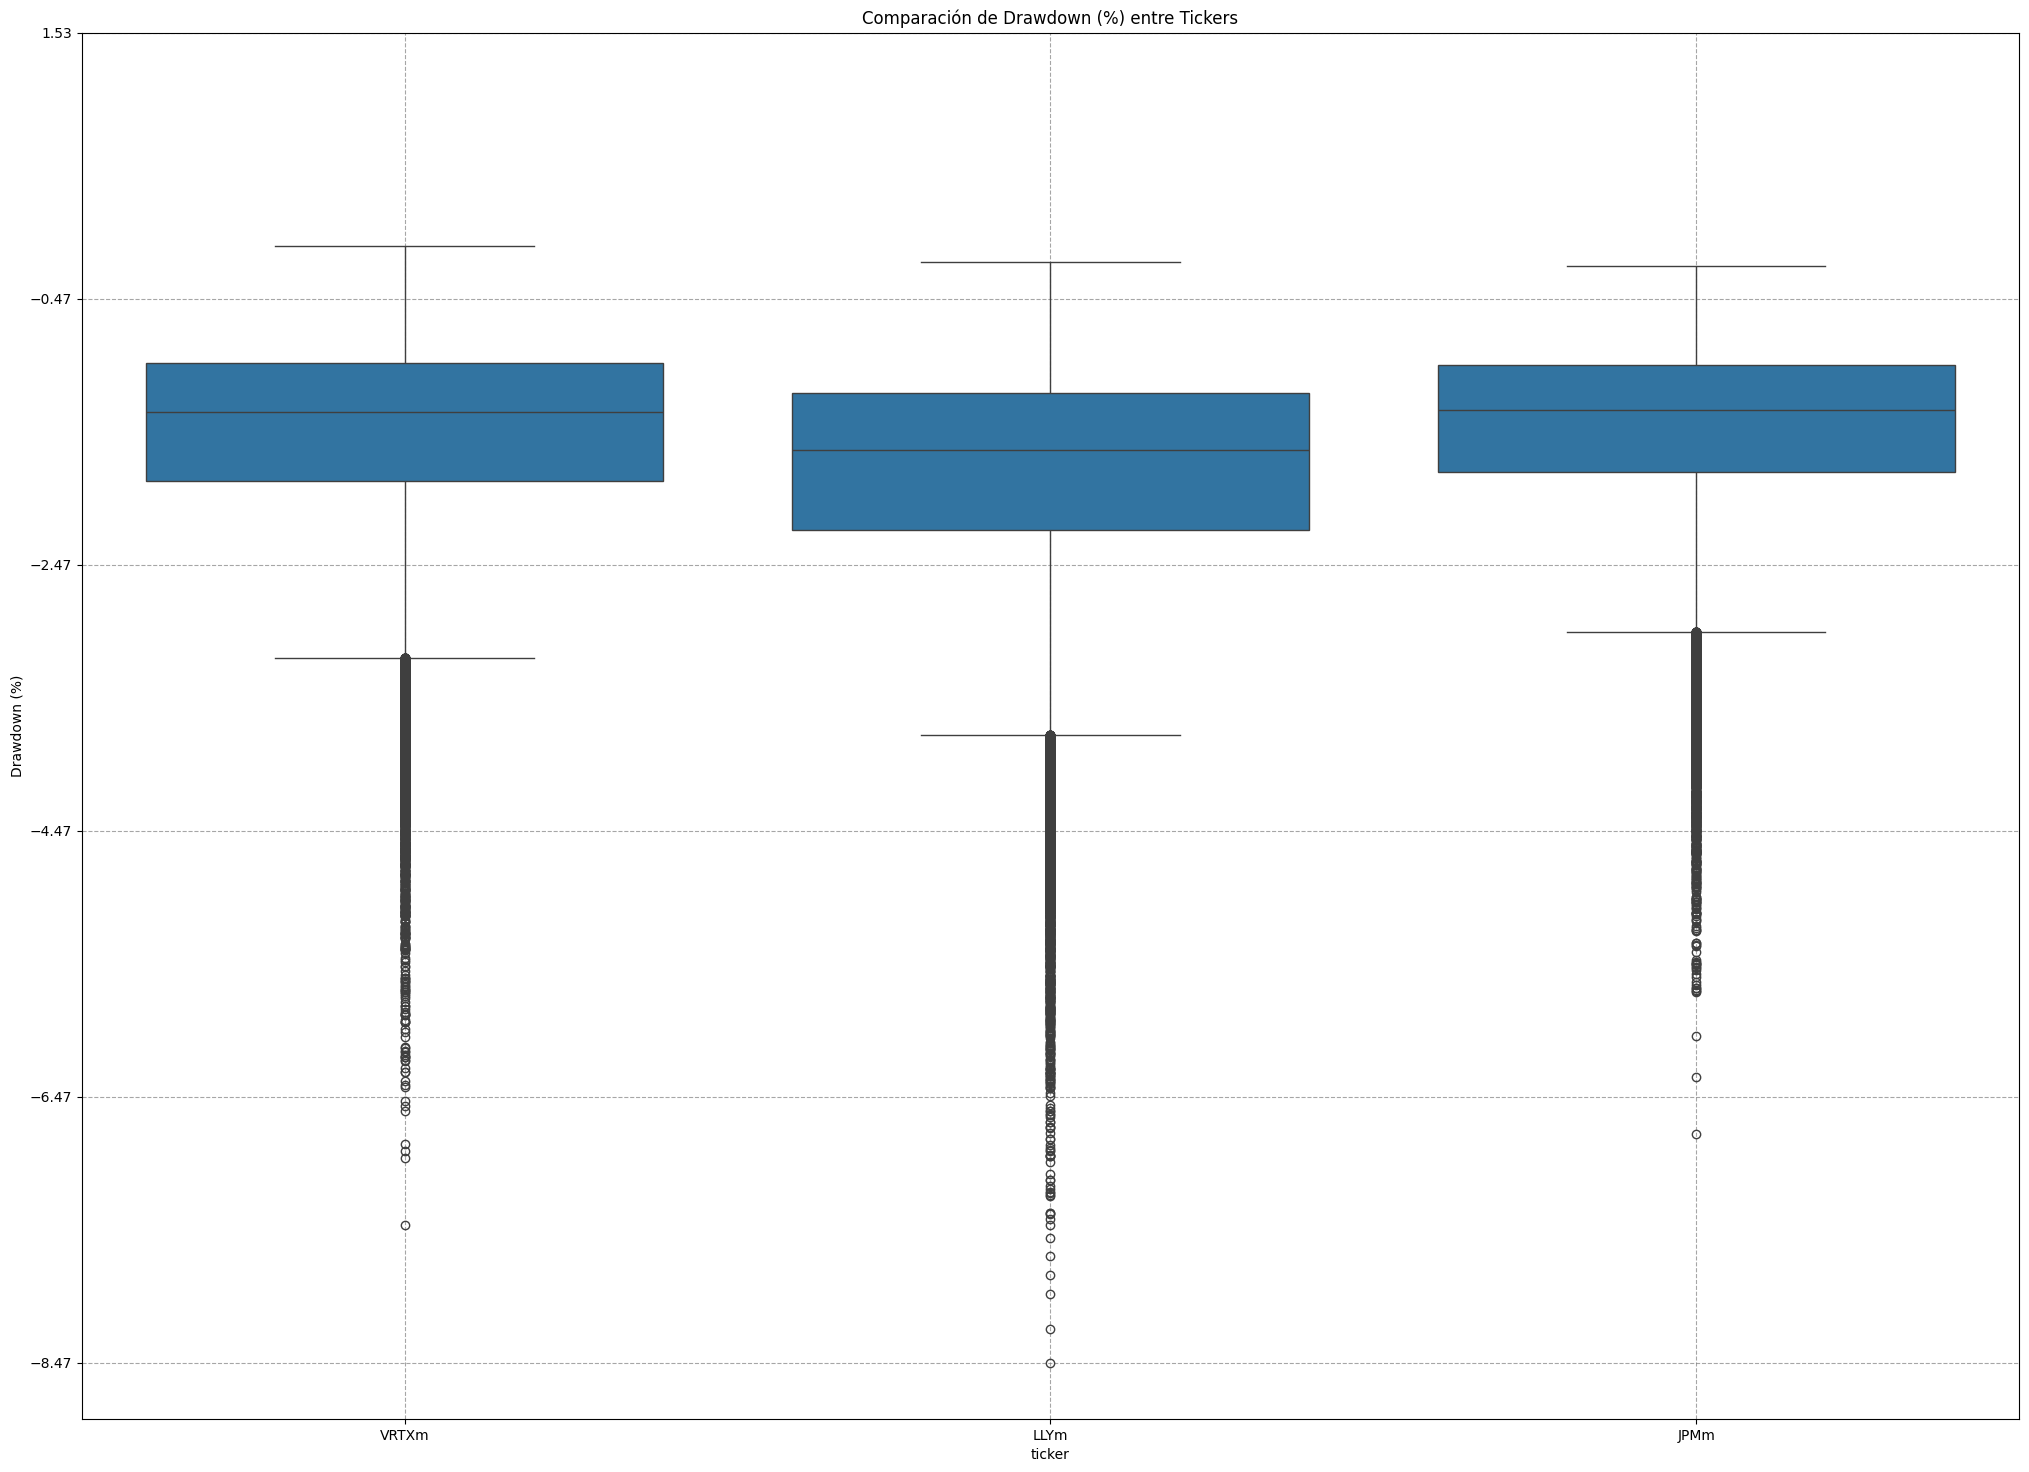

In [38]:
# Configurar el gráfico con matplotlib y seaborn
plt.figure(figsize=(25, 18))
sns.boxplot(data=all_drawdowns, x="ticker", y="Drawdown (%)")
plt.title("Comparación de Drawdown (%) entre Tickers")

y_max = all_drawdowns["Drawdown (%)"].max()  # Valor máximo en el eje Y
y_min = all_drawdowns["Drawdown (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 2  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()


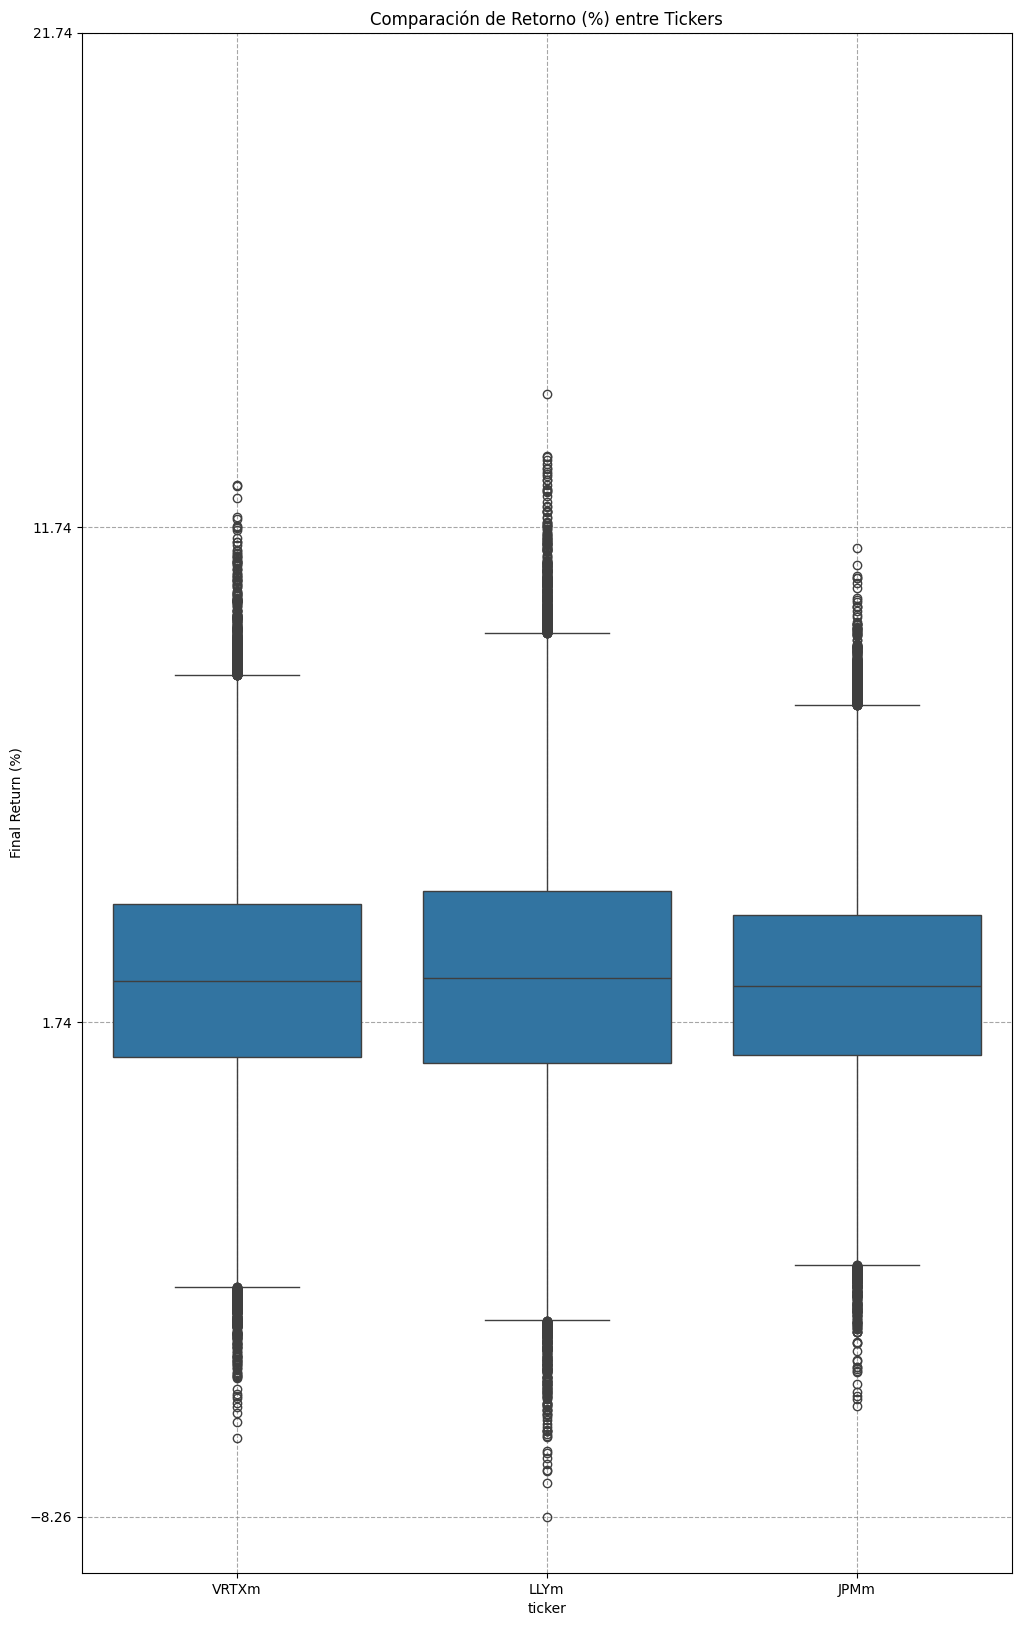

In [39]:
# Generar el gráfico
plt.figure(figsize=(12, 20))
sns.boxplot(data=all_returns, x="ticker", y="Final Return (%)")
plt.title("Comparación de Retorno (%) entre Tickers")

# Configurar ticks mayores con más números
y_max = all_returns["Final Return (%)"].max()  # Valor máximo en el eje Y
y_min = all_returns["Final Return (%)"].min()  # Valor mínimo en el eje Y
tick_interval = 10  # Intervalo deseado entre números en el eje Y

# Configurar los ticks mayores en el eje Y
plt.yticks(np.arange(y_min, y_max + tick_interval, tick_interval))

# Activar la cuadrícula
plt.grid(True, linestyle='--', which='both', color='grey', alpha=0.7)

# Mostrar el gráfico
plt.show()
